## U-Net: Convolutional Networks for Biomedical Image Segmentation
---
### **Introduction**
- Why not CNNs?
  - The typical use of CNNs is on classification tasks, where the output to an image is single class label. However, in many visual tasks, especially in biomedical image processing, **the desired output should be localization, i.e a class label is supposed to be assigned to each pixel.**
  - Also, thousands of training images are usually beyond reach in biomedical tasks.
---
### **Introduction**
- In this paper the authors build the so-called "fully convolutional neural network".
- The main idea is to supplement a usual contracting network by succesive layers increase the resolution of the output.
- In order, to localize high resolution features from the contracting path are combined with the unsampled output.
- A succesive convolution layer can then learn to assemble a more precise output based on this information.
-  The network does not have any fully connected layers and only uses the valid part of each convolution, i.e.,the segmentation map only contains the pixels, for which the full context is available in the input image.
- In the biomedical segmentation tasks very little training data is available, so authors use excessive data augmentation by applying elastic deformations to the available training images.
---
### **Architecture**
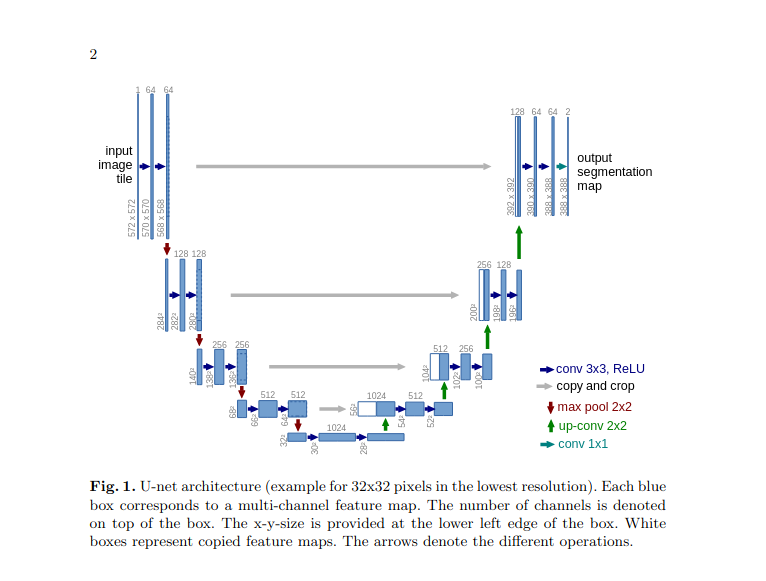
- It consists of a contracting path (left side) and an expensive path (right side). The contracting path follows the typical architecture of a convolutional network.
- It consists of the repeated application of **two 3x3 convolutions (unpadded)**. followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. 
- At each downsampling step we double the number of feature channels.
- Every step is the expansive path consists of the feature map followed by a 2x2 convolution.
- **up convolution** : halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions each followed by a ReLU.
- The cropping is necessary due to loss of border pixels in every convolution.
- At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.
---
### **Training**
- Due to unpadded convolutions, the output image is smaller than the input by a constant border width.
- To minimize the overhead and make maximum use of the GPU memory, we favor large input tiles over a large batch size and hence reduce the batch to a single image.
- we use a high momentum (0.99) such that a large number of the previously seen training samples to determine the update in the current optimization step.
---
- The energy function is computed by a pixel wise sofmax over the final feature map combined with the cross-entropy loss function.


$$
p_k(\mathbf{x}) = \frac{\exp(a_k(\mathbf{x}))}{\sum_{k'=1}^{K} \exp(a_{k'}(\mathbf{x}))}
$$

- where $( a_k(\mathbf{x}) )$ denotes the activation in feature channel $( k )$ at the pixel position $( \mathbf{x} \in \Omega )$ with $( \Omega \subset \mathbb{Z}^2 ). ( K )$ is the number of classes and $( p_k(\mathbf{x}) )$ is the approximated maximum-function. I.e. $( p_k(\mathbf{x}) \approx 1 ) for the ( k )$ that has the maximum activation $( a_k(\mathbf{x}) ) and ( p_k(\mathbf{x})$ approx 0 ) for all other $( k )$. The cross entropy then penalizes at each position the deviation of $( p_{\ell(\mathbf{x})}(\mathbf{x}) )$ from 1 using:

$$
E = \sum_{\mathbf{x} \in \Omega} w(\mathbf{x}) \log (p_{\ell(\mathbf{x})}(\mathbf{x}))
$$

- where $( \ell : \Omega \to \{1, \dots, K\} )$ is the true label of each pixel and $( w : \Omega \to \mathbb{R} )$ is a weight map that we introduced to give some pixels more importance in the training.

- We pre-compute the weight map for each ground truth segmentation to compensate the different frequency of pixels from a certain class in the training data set, and to force the network to learn the small separation borders that we introduce between touching cells.

- The separation border is computed using morphological operations. The weight map is then computed as:

$$
w(\mathbf{x}) = w_c(\mathbf{x}) + w_0 \cdot \exp \left( -\frac{(d_1(\mathbf{x}) + d_2(\mathbf{x}))^2}{2\sigma^2} \right)
$$

- where $( w_c : \Omega \to \mathbb{R})$ is the weight map to balance the class frequencies, $( d_1 : \Omega \to \mathbb{R})$ denotes the distance to the border of the nearest cell and $( d_2 : \Omega \to \mathbb{R})$ the distance to the border of the second nearest cell. In our experiments we set $( w_0 = 10 ) and ( \sigma \approx 5)$ pixels.
- In a CNN with differents paths through the network, a good initialization of the weights is extremely important and for a network with alternating convolutions and ReLU layers this can be achieved by drawing the initial weights from a Gaussian distribution with a standard deviation of $\sqrt(2 / N) $, where N denotes the number of incoming nodes of one neuron. E.g. for a 3 x 3 convolution and 64 feature channels in the previous layer N = 9.64 = 576. 
--- 
### **Data Augmentation**
- It is essential to teach the network the desired invariance and robustness properties.
-  In case of microscopical images we primarily need shift and rotation invariance as well as
robustness to deformations and gray value variations.
- Especially random elas-
tic deformations of the training samples seem to be the key concept to train
a segmentation network with very few annotated images.
-We generate smooth
deformations using random displacement vectors on a coarse 3 by 3 grid. The
displacements are sampled from a Gaussian distribution with 10 pixels standard
deviation. Per-pixel displacements are then computed using bicubic interpola-
tion. Drop-out layers at the end of the contracting path perform further implicit
data augmentation
---
### **Conclusion**
- The u-net architecture achieves very good performance on very different biomedical segmentation applications. Thanks to data augmentation with elastic deformation, it only need very few images and has a very reasonable training time. 

## Simple PyTorch Implementation 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling)
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """ Convolutional block: Conv2D -> ReLU -> Conv2D -> ReLU """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        """ Transposed Convolution (Upsampling) """
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder path
        d4 = torch.cat((self.upconv4(b), e4), dim=1)
        d4 = self.dec4(d4)
        d3 = torch.cat((self.upconv3(d4), e3), dim=1)
        d3 = self.dec3(d3)
        d2 = torch.cat((self.upconv2(d3), e2), dim=1)
        d2 = self.dec2(d2)
        d1 = torch.cat((self.upconv1(d2), e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

# Test the model with a dummy input
model = UNet(in_channels=1, out_channels=1)
x = torch.randn(1, 1, 256, 256)  # Batch size 1, 1 channel, 256x256 image
y = model(x)
print(y.shape)  # Output shape should be (1, 1, 256, 256)


torch.Size([1, 1, 256, 256])


In [3]:
## It is not an implementation by me from scratch but just a representation of the U-net code structure using GPT